# Satellite Use Classification | Unsupervised Learning Approach

## Problem Overview

This project focuses on classifying the purpose of satellites using data provided by the UCS organization. The goal is to explore and test unsupervised learning approaches, K-Means and DBSCAN, to predict a satellite's purpose.

The project aims to identify the most influential features for predicting a satellite's purpose. Additionally, it seeks to address issues of biased data by implementing strategies to mitigate bias in the classification process. This research not only enhances our understanding of satellite usage but also contributes to the development of more accurate and unbiased classification models.

## About the dataset

The dataset I'll be using for this project was compiled by the Union of Concerned Scientists (UCS) from several sources. The dataset contains information about various satellites that are currently or have been in orbit.

The dataset is available here: https://www.ucsusa.org/resources/satellite-database

# Exploratory Data Analysis (EDA) & Data Preparation

In this section we'll be performing exploratory data analysis on the data we're going work with. Preliminary data cleaning has already been completed in the `data_cleaning` notebook. However there are a few additional steps we'll need to take to prepare the data specifically to enter the supervised model we'll be building later on.

In the `supervised_satellite_classification` notebook we did some preliminary EDA and found the data to be biased towards Communications satellites, as they made up more than half of the data set. In this section, we'll explore ways to mitigate that bias.

As a summary here are the steps we'll take in this section:
- Explore bias mitigation techniques
- Visualize the data available for each attribute
- Set up label encodings for text-based data for entering the model

## Loading the Data
Here we load the clean data output from the `data_cleaning` notebook.

In [1]:
import pandas as pd

sat_df = pd.read_csv('satellite_db_clean.csv')
sat_df.head()

,Country of Operator/Owner,Users,Purpose,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Launch Site,Launch Vehicle,Date of Launch,Purpose_subset
0,USA,COMMERCIAL,EARTH OBSERVATION,NON-POLAR INCLINED,0.0,566.0,576.0,0.001510,36.90,96.08,22.0,SATISH DHAWAN SPACE CENTER,PSLV,2019-12-11,EARTH OBSERVATION
1,UNITED KINGDOM,COMMERCIAL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,637.0,654.0,0.001510,98.00,95.00,4.0,CAPE CANAVERAL,FALCON 9,2023-01-03,EARTH OBSERVATION
2,FINLAND,CIVIL,TECHNOLOGY DEVELOPMENT,SUN-SYNCHRONOUS,0.0,497.0,517.0,0.001450,97.45,94.70,4.5,SATISH DHAWAN SPACE CENTER,PSLV,2017-06-23,TECHNOLOGY DEVELOPMENT
3,DENMARK,CIVIL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,442.0,687.0,0.001510,98.20,95.90,1.0,GUIANA SPACE CENTER,SOYUZ-2.1A,2016-04-25,EARTH OBSERVATION
4,MULTINATIONAL,COMMERCIAL,COMMUNICATIONS,EQUATORIAL,75.0,35778.0,35793.0,0.000178,0.08,1436.03,6330.0,GUIANA SPACE CENTER,ARIANE 5 ECA,2014-02-06,COMMUNICATIONS


In [2]:
print(f"This dataset has {sat_df.shape[0]} entries and {sat_df.shape[1]} attributes.")
print(f"Available Attributes:\n\n{sat_df.dtypes}")

This dataset has 7201 entries and 15 attributes.
Available Attributes:

Country of Operator/Owner      object
Users                          object
Purpose                        object
Type of Orbit                  object
Longitude of GEO (degrees)    float64
Perigee (km)                  float64
Apogee (km)                   float64
Eccentricity                  float64
Inclination (degrees)         float64
Period (minutes)              float64
Launch Mass (kg.)             float64
Launch Site                    object
Launch Vehicle                 object
Date of Launch                 object
Purpose_subset                 object
dtype: object


In [3]:
# Set date to correct type
sat_df['Date of Launch'] = pd.to_datetime(sat_df['Date of Launch'])

## Helper Functions for Data Visualization

In [4]:
from re import U
import pandas as pd
import matplotlib.pyplot as plt
# Helpers
def plot_top_n_histogram(df, column_name, n):
    # Get the unique values and their counts
    value_counts = df[column_name].value_counts()

    # If there are more than n unique values, take the top n
    if len(value_counts) > n:
        value_counts = value_counts.head(n)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    # value_counts.plot(kind='hist', density=True)
    (value_counts / len(df)).plot(kind='bar')
    plt.xlabel(f'{column_name} Values')
    plt.ylabel('Density')
    plt.title(f'Top {n} values in {column_name}')
    plt.xticks(rotation=90)
    plt.show()

def box_plot(df: pd.DataFrame, column: str):
  boxplot = df.boxplot(column=column, showfliers=False)
  plt.ylabel(f'{column} Value')
  plt.title(f'Box Plot of {column} Values')
  plt.show()

def plot_dates(df: pd.DataFrame, column: str):
  launches_per_year = df.groupby(df[column].dt.year).size()
  launches_per_year.plot(kind='bar', xlabel='Year', ylabel='Number of Launches', title='Launches by Year')
  plt.show()

def column_overview(df: pd.DataFrame, column: str, show_plot: bool = False, n:int = 50) -> None:
    print(f"Column: {column}")
    print(f"Type: {df[column].dtype}")
    unique_values = df[column].unique()
    print(f"Found {len(unique_values)} unique values")
    if show_plot:
        if df[column].dtype == 'datetime64[ns]':
          plot_dates(df, column)
        elif df[column].dtype == 'float64':
          box_plot(df, column)
        else:
          num_values = len(df[column].unique())
          if num_values < n:
            n = num_values
          plot_top_n_histogram(df, column, n=n)
    else:
      try:
        unique_values = sorted(df[column].unique().tolist())
        print(unique_values)
      except Exception:
        print(unique_values)


## Handling Imbalanced Data

As we can see from the plot below, our classifications are imbalanced. The majority of satellites in our dataset are Communications satellites. In the supervised appraoch I tried undersampling the Communications entries. However the classifications were still fairly imbalanced. In this section we're going to explore Random Over/Under sampling.

For reference, [this](https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de) blog post was helpful in explaining how to use these techniques in python.

Column: Purpose
Type: object
Found 29 unique values


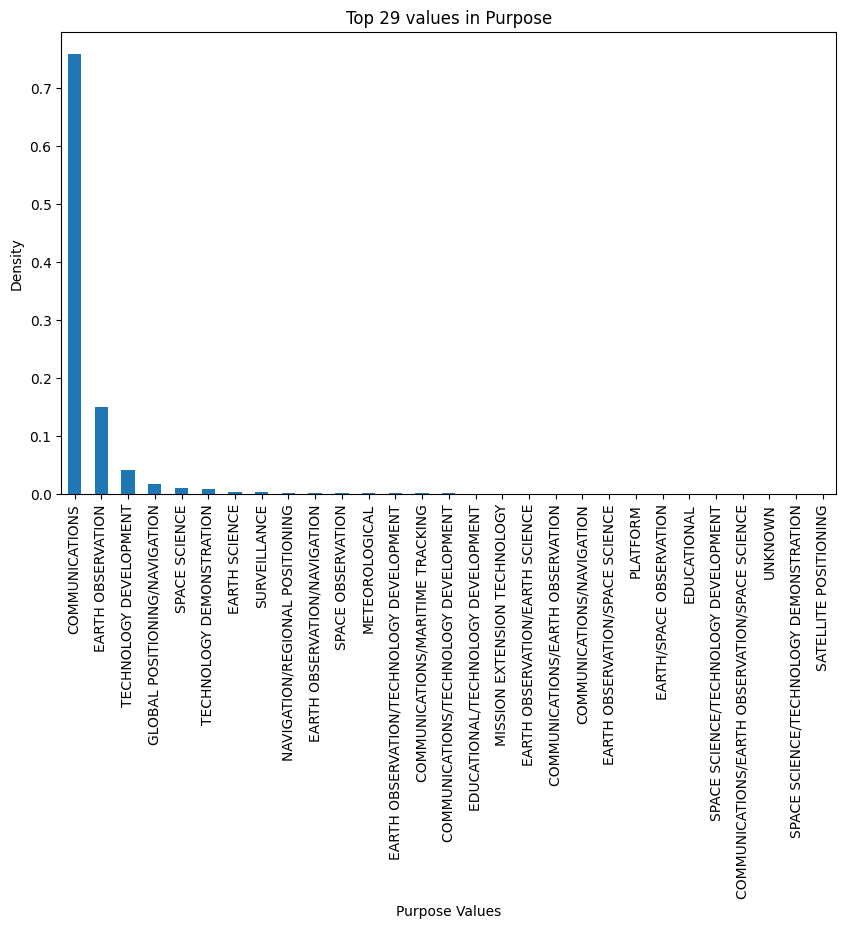

In [5]:
column_overview(sat_df, "Purpose", show_plot=True)

In [6]:
from sklearn.utils import resample

minority_class = sat_df[(sat_df['Purpose'] != 'COMMUNICATIONS') & (sat_df['Purpose'] != 'EARTH OBSERVATION') & (sat_df['Purpose'] != 'TECHNOLOGY DEVELOPMENT')]
majority_class = sat_df[(sat_df['Purpose'] == 'COMMUNICATIONS') | (sat_df['Purpose'] == 'EARTH OBSERVATION') | (sat_df['Purpose'] == 'TECHNOLOGY DEVELOPMENT')]

# Upsample the minority classes
minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)/2), random_state=55)
# Downsample the majority classes
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class)*2, random_state=5)

# Combine the downsampled majority and upsampled minority
balanced_data = pd.concat([minority_upsampled, majority_downsampled])
print(balanced_data.shape)

(4137, 15)


Column: Purpose
Type: object
Found 29 unique values


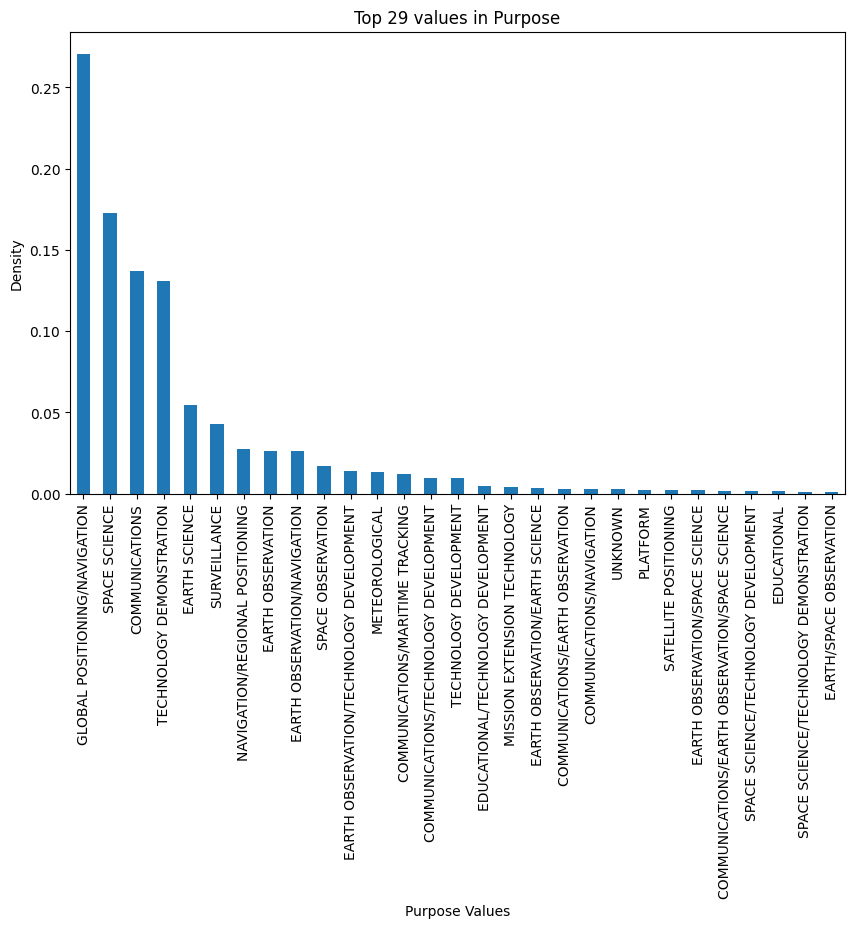

In [7]:
column_overview(balanced_data, "Purpose", show_plot=True)

## Exploratory Data Analysis - Balanced Data

In the `supervised_satellite_classification` notebook, we did some initial analysis on the original imbalanced data. In this section I'll generate a handful of plots to get an idea for the balanced data and for how the data are distributed.

Column: Country of Operator/Owner
Type: object
Found 102 unique values


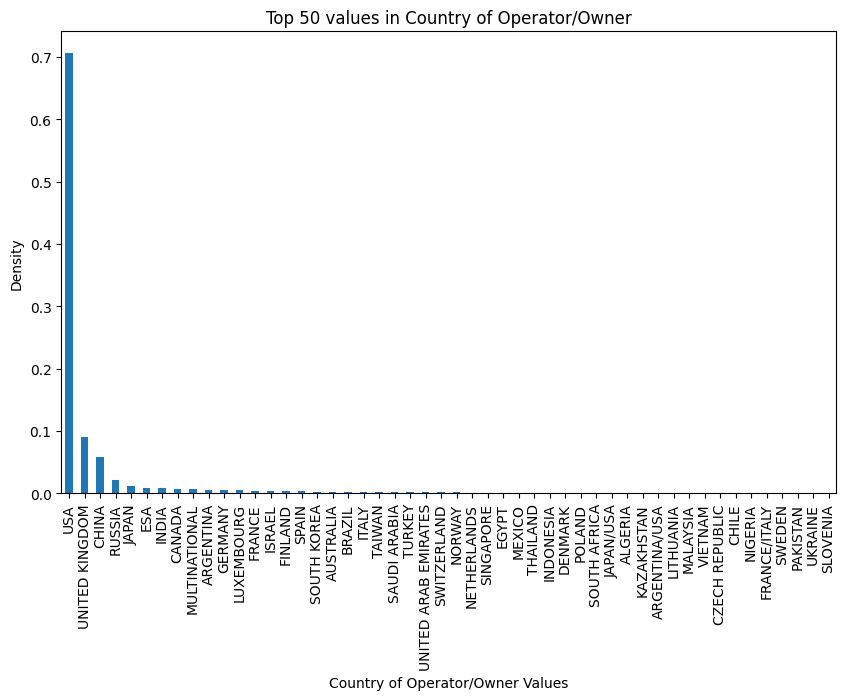

Column: Users
Type: object
Found 11 unique values


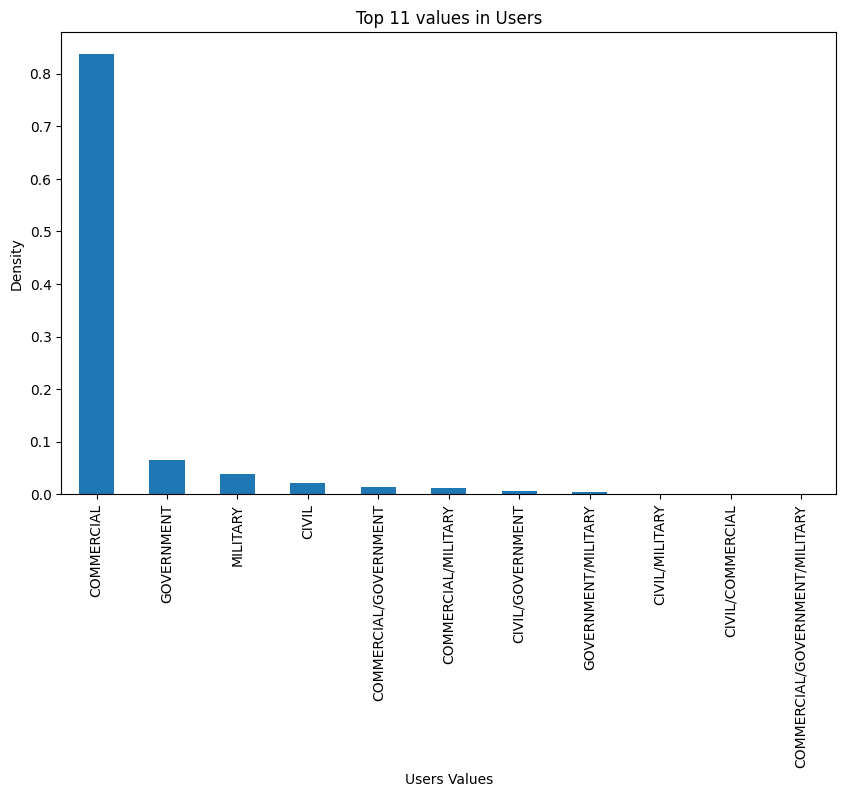

Column: Purpose
Type: object
Found 29 unique values


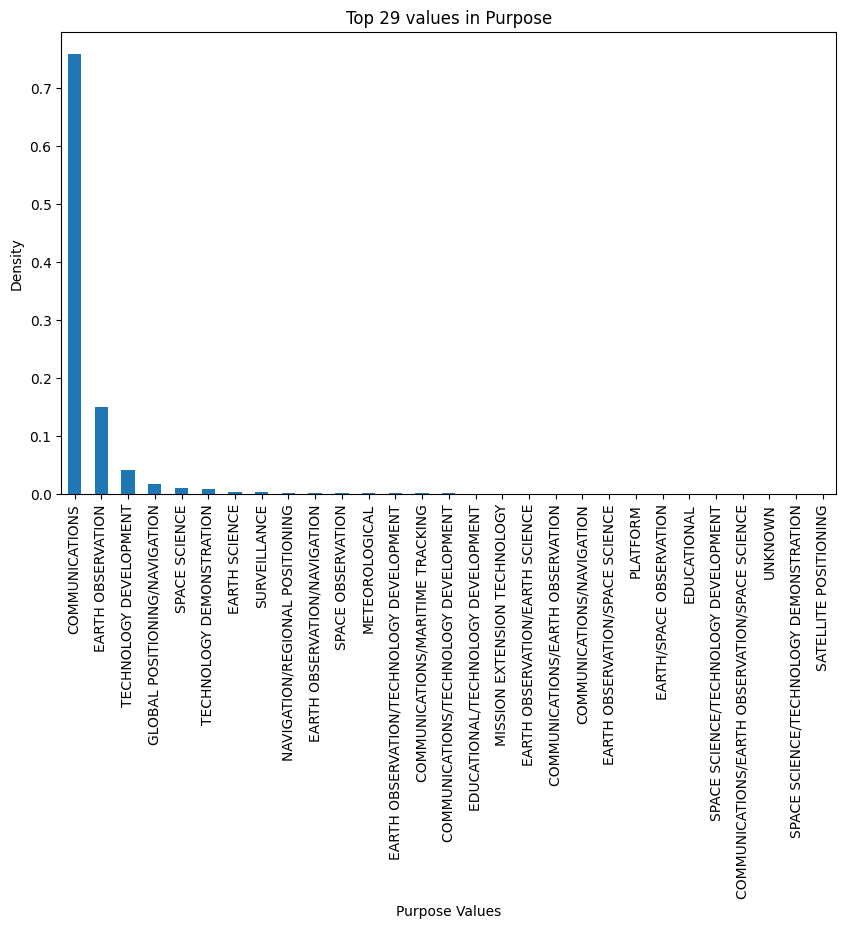

Column: Type of Orbit
Type: object
Found 10 unique values


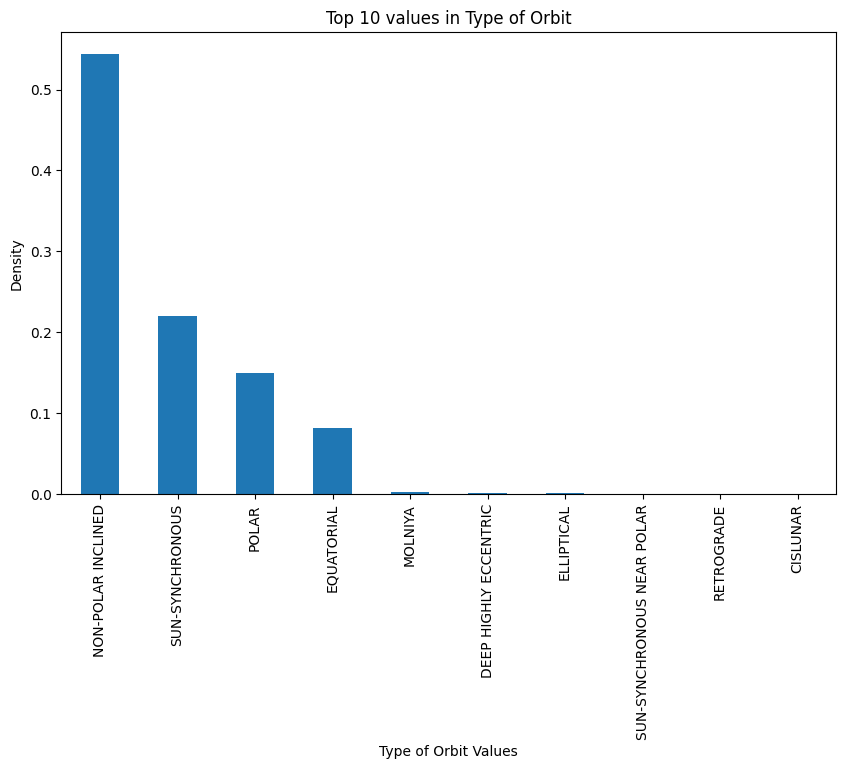

Column: Longitude of GEO (degrees)
Type: float64
Found 422 unique values


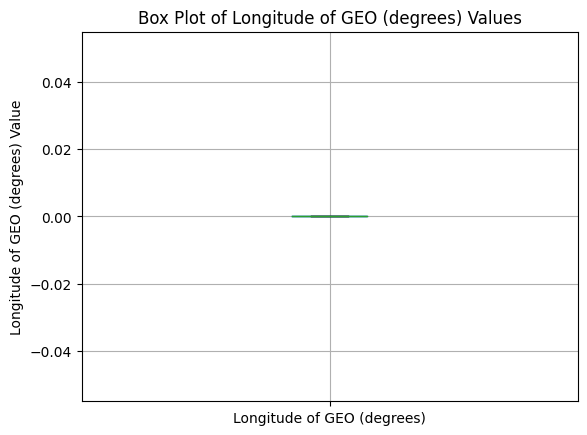

Column: Perigee (km)
Type: float64
Found 713 unique values


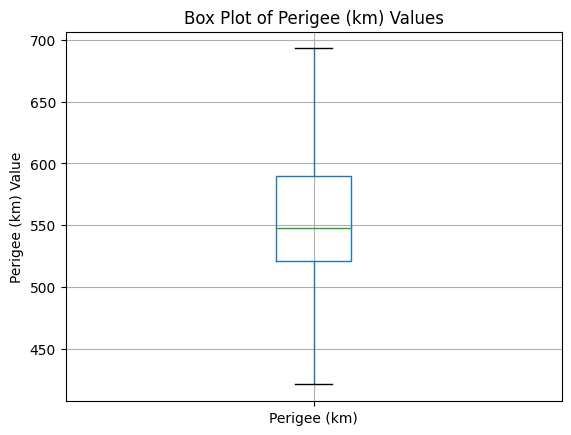

Column: Apogee (km)
Type: float64
Found 699 unique values


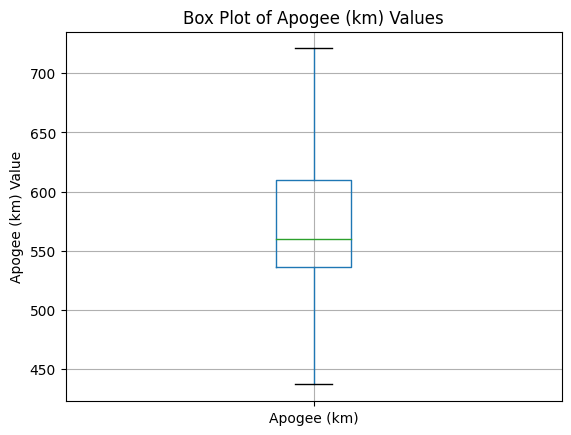

Column: Eccentricity
Type: float64
Found 1654 unique values


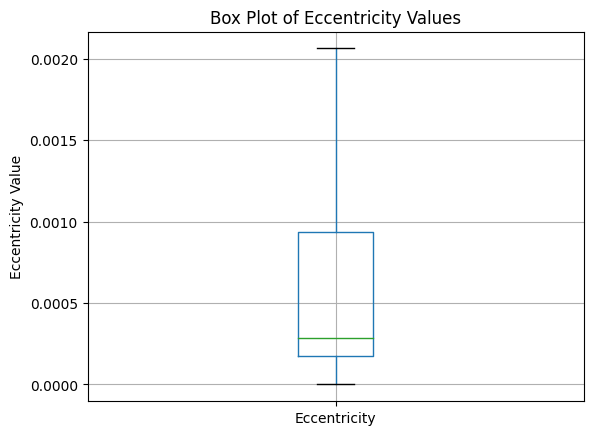

Column: Inclination (degrees)
Type: float64
Found 395 unique values


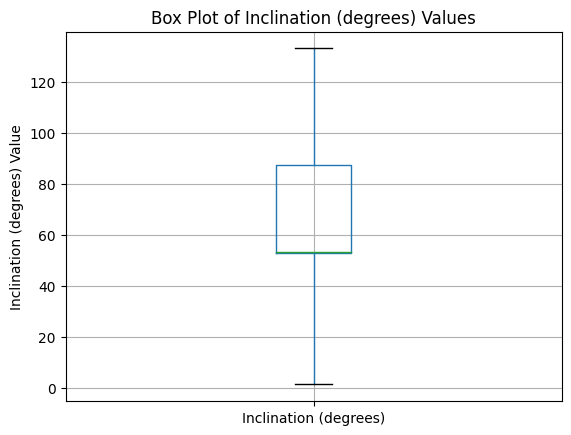

Column: Period (minutes)
Type: float64
Found 513 unique values


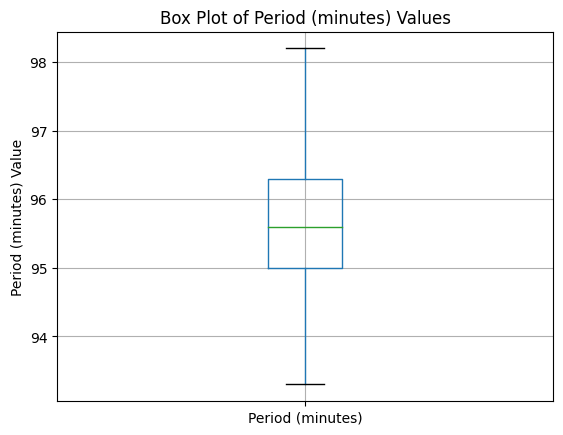

Column: Launch Mass (kg.)
Type: float64
Found 586 unique values


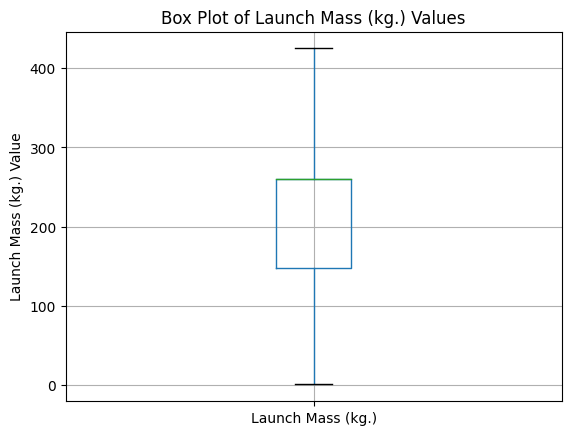

Column: Launch Site
Type: object
Found 38 unique values


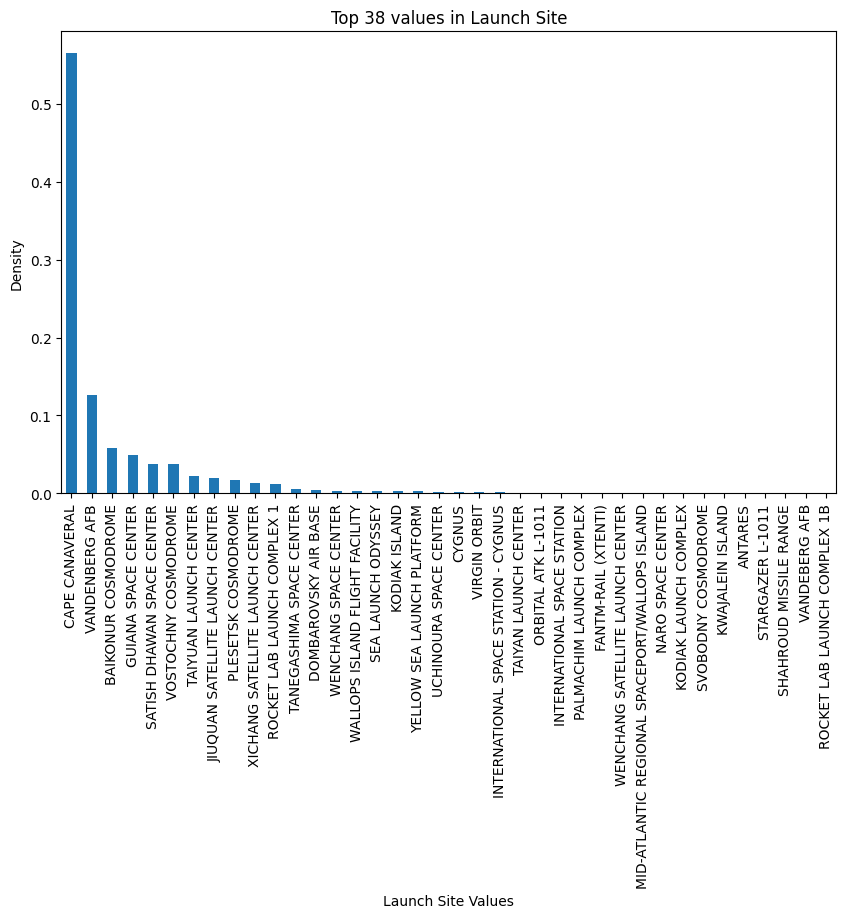

Column: Launch Vehicle
Type: object
Found 155 unique values


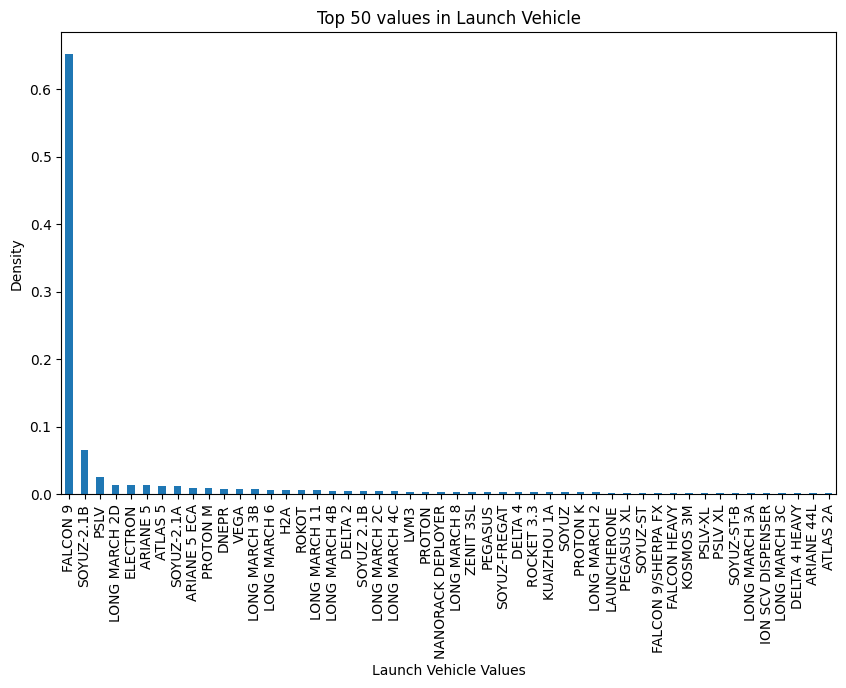

Column: Date of Launch
Type: datetime64[ns]
Found 1089 unique values


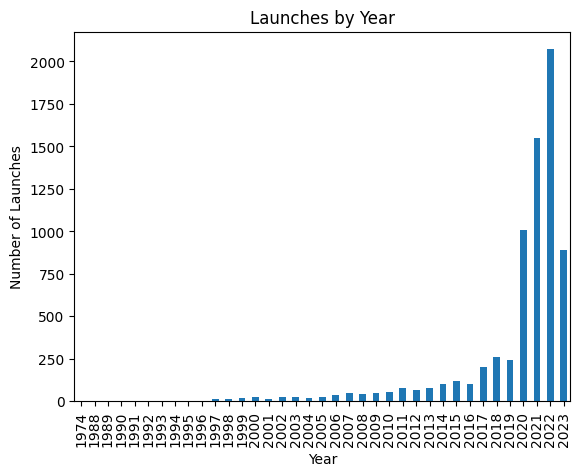

Column: Purpose_subset
Type: object
Found 16 unique values


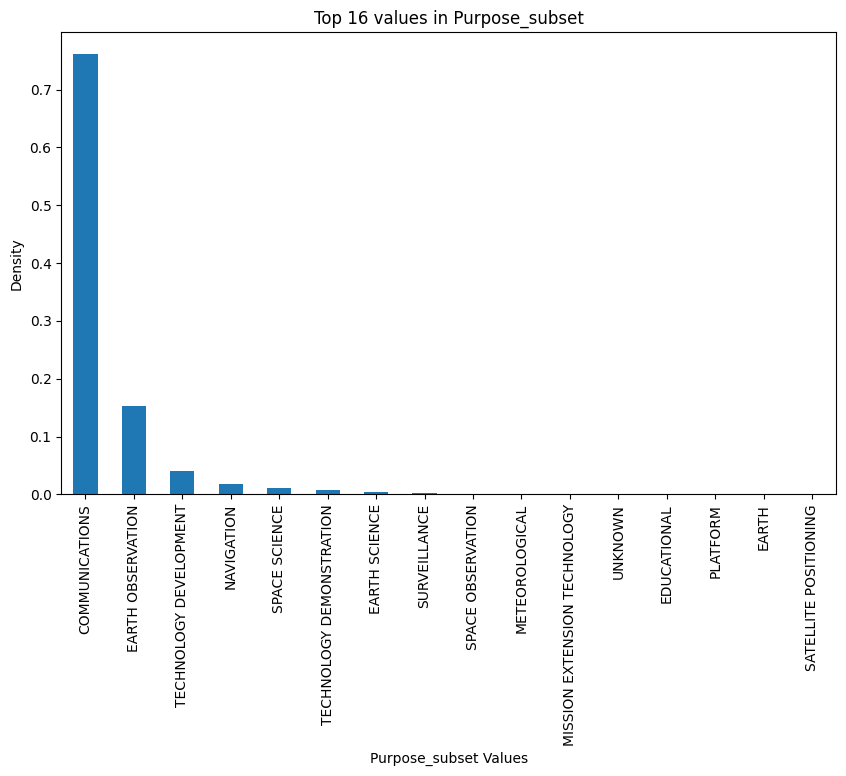

In [8]:
for column in balanced_data.columns:
  column_overview(sat_df, column, show_plot=True)

## Data Preparation
While the data has been cleaned already, we need to prepare the data to enter the models we'll be developing. In general, models don't work well with text based data unless you are creating an NLP model, so in this section we'll be creating label encodings for the text-based attributes we have to work with.


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_mappings = {} # Used to keep track of mappings in case we need them later
categorical_feats = []
for col in sat_df.columns:
    if sat_df[col].dtype == 'object':
        sat_df[f'{col}_encoded'] = le.fit_transform(sat_df[col])
        sat_df[col] = pd.Categorical(sat_df[col])
        balanced_data[f'{col}_encoded'] = le.fit_transform(balanced_data[col])
        balanced_data[col] = pd.Categorical(balanced_data[col])
        class_mapping = {index: label for index, label in enumerate(le.classes_)}
        encoded_mappings[col] = class_mapping
        categorical_feats.append(col)

# Model Building

In this section we will build two types of unsupervised models: K-means and DBSCAN classifiers. The goal is to see if we can reliably classify Satellite use based on some factors to be determined.


TODO: CLARIFY - First we'll perform preliminary feature selection based on a combination of correlation + iterating through feature choices to see which produce highest accuracy. After we'll build our models and apply different methods to try and negate biases in our data.


In [10]:
# During model building we'll track model performance with the results df
models = []
results = pd.DataFrame(columns=['DataFrame', 'Model', 'Features', 'Target', 'Accuracy'])

def add_to_results(df_name, model, model_type, features, target, accuracy):
  global results
  new_row = {'DataFrame':df_name,'Model': model_type, 'Features': features, 'Target': target, 'Accuracy':accuracy}
  models.append(model)
  results.loc[len(results)] = new_row



In [11]:
real_labels = sat_df['Purpose'].unique()

## K-Means

In [12]:
# KMEANS DOESN"T ALLOW CATEGORICAL - drop those and target columns for input
import numpy as np
numerical_columns = sat_df.select_dtypes(include=[np.number]).columns
sat_df_numeric = sat_df[numerical_columns]
balanced_data_numeric = balanced_data[numerical_columns]
sat_df_numeric = sat_df_numeric.drop(['Purpose_encoded', 'Purpose_subset_encoded'], axis=1)
balanced_data_numeric = balanced_data_numeric.drop(['Purpose_encoded', 'Purpose_subset_encoded'], axis=1)


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

import itertools


def label_permute_compare(ytdf,yp, n):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    # get label values + create list of possible permutations
    label_permutations = list(itertools.permutations(range(n)))
    best_label = None
    best_accuracy = 0
    for permutation in label_permutations:
        # Map permutation to real label values
        label_map = {permutation[i]: label for i, label in enumerate(real_labels)}
        # Map yp to use permuted labels
        yp_new = [label_map[value] for  value in yp]
        accuracy = accuracy_score(ytdf, yp_new)
        # Update if accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_label = permutation
#             print(label_map, accuracy)
    return best_label, best_accuracy

# # get mapped values again
# real_labels = ['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD']
# label_map = {labelorder[i]: label for i, label in enumerate(real_labels)}
# yp_new = [label_map[value] for  value in model.labels_]

# # create confusion matrix from results
# conf_matrix = confusion_matrix(label, yp_new)
# print(conf_matrix)

def build_and_predict_kmeans(data, k):
  # Create a KMeans object with the number of clusters you want
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=55)
  # Fit the KMeans model to your data
  kmeans.fit(data)
  return kmeans.labels_

In [ ]:
n = len(real_labels)
yp = build_and_predict_kmeans(sat_df_numeric, k=n)
print(label_permute_compare(sat_df['Purpose'],yp, n=n))


## Model One: Original Data

Now that we've picked our model features, lets evaluate the model.


## Model Two: Balanced Data


# Step Four: Results and Analysis

In [ ]:
results_sorted = results.sort_values(by='Accuracy', ascending=False)
results_sorted.head(50)

TODO: Complete this section

# Step Five: Conclusions

TODO: Complete this section